In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


In [15]:
# 문장길이의 평균값, 최대값, 표준편차를 다시 계산해본다.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


In [17]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


In [20]:
vocab_size = len(index_to_word)
word_vector_dim = 300

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

Cnn_model = keras.Sequential()
Cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.MaxPooling1D(5))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.GlobalMaxPooling1D())
Cnn_model.add(keras.layers.Dense(8, activation='relu'))
Cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [22]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [23]:

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [25]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results


----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 11s 44ms/step - loss: 0.3994 - accuracy: 0.8106 - val_loss: 0.3228 - val_accuracy: 0.8591
Epoch 2/20
247/247 [==============================] - 8s 34ms/step - loss: 0.2709 - accuracy: 0.8882 - val_loss: 0.3197 - val_accuracy: 0.8637
Epoch 3/20
247/247 [==============================] - 8s 34ms/step - loss: 0.1800 - accuracy: 0.9311 - val_loss: 0.3580 - val_accuracy: 0.8585
Epoch 4/20
247/247 [==============================] - 8s 34ms/step - loss: 0.0971 - accuracy: 0.9660 - val_loss: 0.4739 - val_accuracy: 0.8531
Epoch 5/20
247/247 [==============================] - 8s 34ms/step - loss: 0.0569 - accuracy: 0.9815 - val_loss: 0.5348 - val_accuracy: 0.8461
Epoch 6/20
247/247 [==============================] - 8s 34ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.6814 - val_accuracy: 0.8464
Epoch 7/20
247/247 [==============================] - 8s 34ms/step - loss: 0.0

In [26]:
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.8505197763442993
CNN 	 0.8406534194946289
GMP 	 0.824623167514801


In [28]:
word_vector_dim = 1000  # 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# CNN을 추가했을 때
# model.add(keras.layers.Conv1D(8, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D())
# LSTM 레이어를 두개로 학습했을 때
# model.add(keras.layers.LSTM(256, dropout=0.7, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 10,579,089
Trainable params: 10,579,089
Non-trainable params: 0
_________________________________________________________________


In [30]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8200
Epoch 00001: val_accuracy improved from -inf to 0.85390, saving model to model.h5
986/986 [==============================] - 74s 75ms/step - loss: 0.3914 - accuracy: 0.8200 - val_loss: 0.3303 - val_accuracy: 0.8539
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8667
Epoch 00002: val_accuracy improved from 0.85390 to 0.86160, saving model to model.h5
986/986 [==============================] - 73s 74ms/step - loss: 0.3094 - accuracy: 0.8667 - val_loss: 0.3187 - val_accuracy: 0.8616
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8831
Epoch 00003: val_accuracy improved from 0.86160 to 0.86645, saving model to model.h5
986/986 [==============================] - 73s 74ms/step - loss: 0.2742 - accuracy: 0.8831 - val_loss: 0.3108 - val_accuracy: 0.8665
Epoch 4/20
986/986 [==============================] - ETA: 0s

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3409 - accuracy: 0.8617
[0.3408955931663513, 0.8616676926612854]


In [33]:
history_dict = history.history

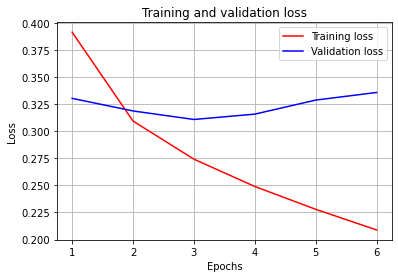

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 1000)


In [36]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기쁨']

In [38]:
word_vectors.similar_by_word("기쁨")

[('슬퍼요', 0.5188561081886292),
 ('색다르', 0.515166699886322),
 ('신들린', 0.5050404071807861),
 ('이영애', 0.5040378570556641),
 ('완소', 0.502723753452301),
 ('멋져요', 0.5004808306694031),
 ('love', 0.495347797870636),
 ('Good', 0.49451780319213867),
 ('귓가', 0.49305373430252075),
 ('웰메이드', 0.49173200130462646)]